# 环境说明

In [10]:
!python -V

Python 3.11.5


In [6]:
import sklearn
import pandas
import numpy
import matplotlib

In [3]:
sklearn.__version__

'1.5.2'

In [4]:
pandas.__version__

'2.1.1'

In [7]:
numpy.__version__

'1.26.4'

In [14]:
matplotlib.__version__

'3.8.0'

# 代码实现

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve

In [7]:
df = pd.read_csv("data/predict.csv")

In [29]:
df.head()

,origin_encoder,predict_encoder,predict_probability
0,0,1,0.506371
1,0,0,0.020811
2,0,0,0.028086
3,0,0,0.107581
4,0,0,0.045805


In [9]:
y_true = df['origin_encoder']  # 原始数据的真实数值，二分类
y_prob = df['predict_probability']  # 模型预测的概率，0到1之间

<Axes: >

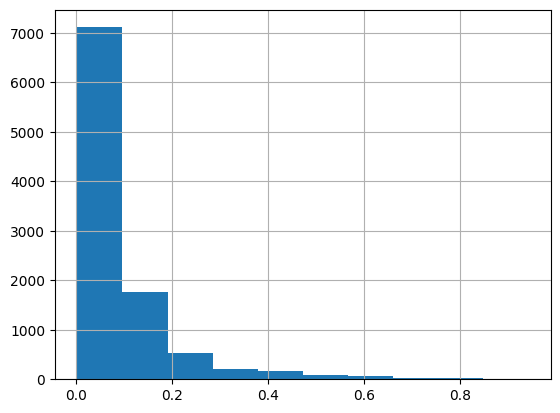

In [35]:
y_prob.hist()

In [10]:
is_boot = True

In [27]:
prob_true

array([0.01      , 0.013     , 0.011     , 0.023     , 0.045     ,
       0.04404404, 0.094     , 0.135     , 0.207     , 0.357     ])

In [28]:
prob_pred

array([0.01054208, 0.01846218, 0.02668482, 0.03622709, 0.04755301,
       0.06234611, 0.08177593, 0.10993871, 0.16160136, 0.36999844])

In [30]:
sum(prob_pred)

0.925129722790581

In [31]:
prob_pred

array([0.01054208, 0.01846218, 0.02668482, 0.03622709, 0.04755301,
       0.06234611, 0.08177593, 0.10993871, 0.16160136, 0.36999844])

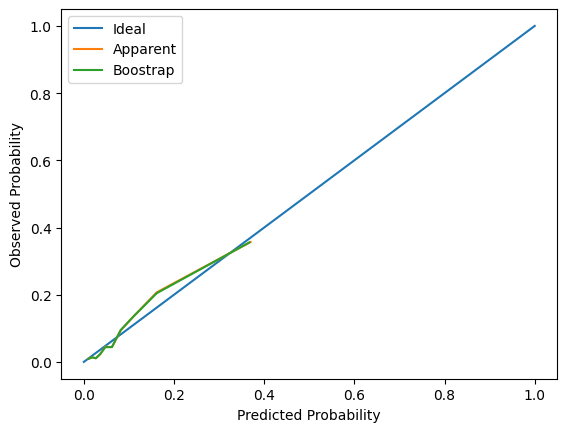

In [26]:
# 计算普通的校准曲线
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='quantile')
# "Ideal" 理想校准曲线 (y=x)
ideal_line = [0, 1]
plt.figure()
# 开始画图
# Ideal (理想曲线)
plt.plot(ideal_line, ideal_line, label='Ideal')
# Apparent (表观曲线)
plt.plot(prob_pred, prob_true, label='Apparent')
# 是否进行Boostrap有放回的采样
if is_boot:
    length = len(y_true)
    boot_num = int(90 * length / 100)
    np.random.seed(1024)  # 设置随机种子
    bootstrap_curves = []
    for i in range(100):
        indices = np.random.choice(length, boot_num, replace=True)
        y_resample_probs = y_prob[indices]
        y_resample_true = y_true[indices]
        # 计算重采样后的校准曲线
        boot_prob_true, boot_prob_pred = calibration_curve(y_resample_true, y_resample_probs, n_bins=10, strategy='quantile')
        # https://chatgpt.com/share/670f779b-c910-8010-92ab-7587668e7f48
        # 使用插值来保证所有曲线的长度一致
        # 对 true 和 pred 都进行插值，确保曲线长度一致
        boot_prob_true_interp = np.interp(prob_pred, boot_prob_pred, boot_prob_true)
        boot_prob_pred_interp = np.interp(prob_pred, boot_prob_pred, boot_prob_pred)
        # 将插值后的校准曲线保存
        bootstrap_curves.append((boot_prob_true_interp, boot_prob_pred_interp))
    # 计算偏差校正后的平均校准曲线
    mean_prob_true = np.mean([curve[0] for curve in bootstrap_curves], axis=0)
    mean_prob_pred = np.mean([curve[1] for curve in bootstrap_curves], axis=0)
    plt.plot(mean_prob_pred, mean_prob_true,label='Boostrap')
# 设置标签和图例
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.legend()